**2η Εργαστηριακή Άσκηση στο μάθημα Ψηφιακή Επεξεργασία Σήματος 2024**

| Ονοματεπώνυμα | ΑΜ |
|----------------|----|
| Γεώργιος Αλέξανδρος Γεωργαντζάς        | 03120017 |
| Βλάσιος Σκουλής        | 03120065 |

**Μέρος 1ο - Ψυχοακουστικό Μοντέλο 1**

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io.wavfile import write
import scipy as sp
import IPython
import soundfile as sf

/var/folders/0s/3zzp9lz97h34qxk2kjr5c5wh0000gn/T/ipykernel_68605/3700291190.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, music_stereo = sp.io.wavfile.read('./dsp24_material_lab2/music_dsp2024.wav')


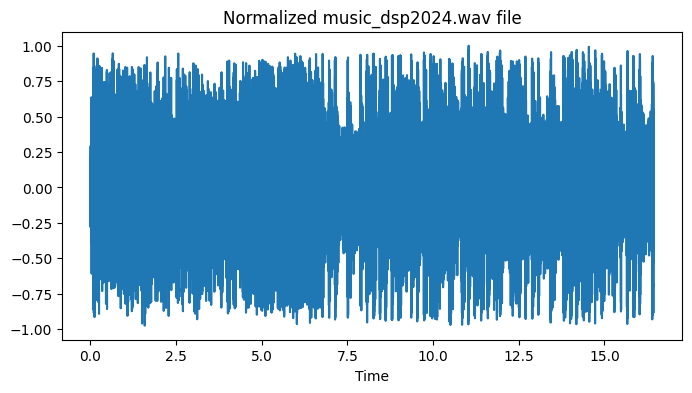

In [259]:
# 1.0

# Read the stereo audio file
fs, music_stereo = sp.io.wavfile.read('./dsp24_material_lab2/music_dsp2024.wav')

# Convert stereo to mono
music = np.mean(music_stereo, axis=1)

# Normalize the audio to range from -1 to 1
max_abs = np.max(np.abs(music))
music = music / max_abs

# Create time array
time = np.arange(len(music)) / fs

# Plot the normalized mono audio in time domain
fig = plt.figure(figsize=(8, 4))
plt.plot(time, music)
plt.xlabel('Time')
plt.title('Normalized music_dsp2024.wav file')
plt.show()

# Display the normalized mono audio
IPython.display.display(IPython.display.Audio(data=music, rate=fs))

In [191]:
# 1.1

def bark_scale(f):
    """
    Frequency (Hz) to Bark scale converter
    
    Args:
    f: input array of frequencies in Hz
    
    Returns:
    b: frequencies converted to Bark scale
    """
    b = 13 * np.arctan(0.00076 * f) + 3.5 * np.arctan((f / 7500) ** 2)
    return b

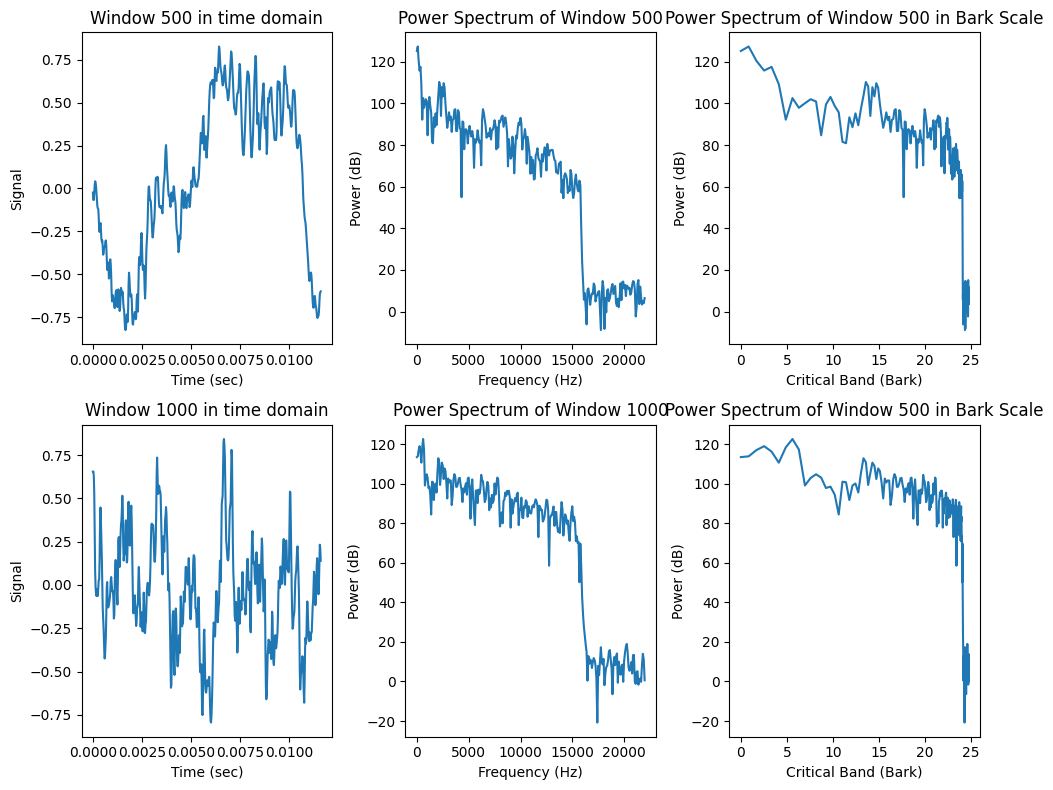

In [192]:
# 1.1

# Define parameters
L = 512  # Length of each window
N = 512  # FFT size
hop_size = 0  # Hop size between windows
PN = 90.302
# Create hanning and rectangular windows
hanning = np.hanning(L)

# Pad music so that it can be devided by hanning windows
pad_width = len(hanning) - len(music) % len(hanning)
music_padded = np.pad(music, pad_width=(0, pad_width), mode='constant', constant_values=0)

# Initialize list to store FFT results
segments_fft_list = []

# Initialize list to store Power Spectrum results
P_k = []

# Segment total signal into windows, apply windows, and compute FFT
for i in range(0, len(music_padded), L+hop_size):
    segment = music_padded[i:i+L] * hanning
    segment_fft = np.fft.fft(segment, N)
    segment_fft = np.abs(segment_fft)
    segments_fft_list.append(segment_fft)

# Calculate Power Spectrum of each window
for window_fft in segments_fft_list:
    P_k.append((PN+10*np.log10(window_fft**2))[:N//2])

P_k = np.array(P_k).transpose()
#Parameters for plotting

window_time = np.linspace(0, 511, 512)
window_time = window_time/fs
window_0 = 500
window_1 = 1000
freqs = np.fft.fftfreq(N, d=1/fs)
freqs = freqs[:N//2]
bark_freqs = bark_scale(freqs)
plt.figure(figsize=(10, 8))

# Plot 1
plt.subplot(2, 3, 1)
plt.plot(window_time, music[N*window_0:N*(window_0+1)])
plt.xlabel('Time (sec)')
plt.ylabel('Signal')
plt.title('Window 500 in time domain')

# Plot 2
plt.subplot(2, 3, 2)
plt.plot(freqs, P_k[:, window_0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Power Spectrum of Window 500')

# Plot 3
plt.subplot(2, 3, 3)
plt.plot(bark_freqs, P_k[:, window_0])
plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power (dB)')
plt.title('Power Spectrum of Window 500 in Bark Scale')

# Plot 4
plt.subplot(2, 3, 4)
plt.plot(window_time, music[N*window_1:N*(window_1+1)])
plt.xlabel('Time (sec)')
plt.ylabel('Signal')
plt.title('Window 1000 in time domain')

# Plot 5
plt.subplot(2, 3, 5)
plt.plot(freqs, P_k[:, window_1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Power Spectrum of Window 1000')

# Plot 6
plt.subplot(2, 3, 6)
plt.plot(bark_freqs, P_k[:, window_1])
plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power (dB)')
plt.title('Power Spectrum of Window 500 in Bark Scale')
# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

In [193]:
# 1.2

def dk(k):
    """
    Range that will be used in the computation of tone masks

    Args:
    k: distinct frequency

    Returns:
    D_k: range based on input frequency
    """
    if 2 < k < 63:
        D_k = [2, 2]
    elif k < 127:
        D_k = [2, 3]
    elif k <= 250:
        D_k = [2, 6]
    else:
        D_k = [0, 0]
    return D_k

# Load P_NM
P_NM = np.load("./dsp24_material_lab2/P_NM-24.npy")

def find_masks(window):
    """
    Find tonal masks based on the power spectrum.

    Args:
    window: Power Spectrum of a Window

    Returns:
    ST: Boolean array indicating tonal masks of input window
    """
    st = np.zeros_like(window, dtype=bool)  # Initialize tonal mask array

    # Find tonal masks
    for k in range(2, 250):
        d1, d2 = dk(k)
        if window[k] > window[k - 1] and window[k] > window[k + 1] and window[k] > window[k - d1] + 7 and window[k] > window[k + d1] + 7 and window[k] > window[k - d2] + 7 and window[k] > window[k + d2] + 7:
            st[k] = 1
    return st

ST = np.zeros_like(P_k)
P_TM = np.zeros_like(ST)
#Find tonal masks off all windows
for window in range(P_k.shape[1]):
    ST[:, window] = find_masks(P_k[:, window])
    for k in range(ST[:, window].shape[0]):
        if ST[k, window] == 1:
            P_TM[k, window] = 10 * np.log10(10**(0.1 * P_k[k, window]) + 10**(0.1 * P_k[k, window]) + 10**(0.1 * P_k[k, window]))

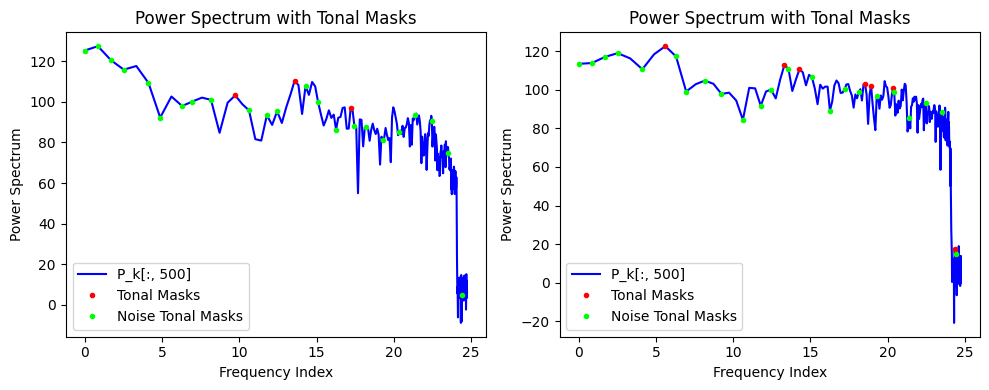

In [194]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(bark_freqs, P_k[:, window_0], color='blue', label='P_k[:, 500]')
# Overlay positions of tonal masks with red color
mask_indices = np.where(P_TM[:, window_0] != 0)[0]
noise_mask_indices = np.where(P_NM[:, window_0] != 0)[0]
plt.plot(bark_freqs[mask_indices], P_k[mask_indices, window_0], 'ro', label='Tonal Masks', markersize=3)
plt.plot(bark_freqs[noise_mask_indices], P_k[noise_mask_indices, window_0], 'o', color='lime', label='Noise Tonal Masks', markersize=3)
# Set labels and title
plt.xlabel('Frequency Index')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum with Tonal Masks')
# Add legend
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bark_freqs, P_k[:, window_1], color='blue', label='P_k[:, 500]')
# Overlay positions of tonal masks with red color
mask_indices = np.where(P_TM[:, window_1] != 0)[0]
noise_mask_indices = np.where(P_NM[:, window_1] != 0)[0]
plt.plot(bark_freqs[mask_indices], P_k[mask_indices, window_1], 'ro', label='Tonal Masks', markersize=3)
plt.plot(bark_freqs[noise_mask_indices], P_k[noise_mask_indices, window_1], 'o', color='lime', label='Noise Tonal Masks', markersize=3)
# Set labels and title
plt.xlabel('Frequency Index')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum with Tonal Masks')
# Add legend
plt.legend()
# Show plot
plt.tight_layout()
plt.show()

<StemContainer object of 3 artists>

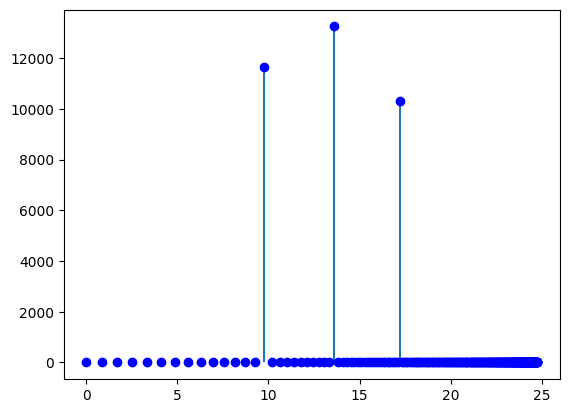

In [195]:
plt.stem(bark_freqs, P_TM[:, window_0]**2, linefmt='', markerfmt='bo', basefmt=' ')

In [196]:
#1.3

# Load P_NMc
P_NMc = np.load("./dsp24_material_lab2/P_NMc-24.npy")

# Load P_TMc
P_TMc = np.load("./dsp24_material_lab2/P_TMc-24.npy")

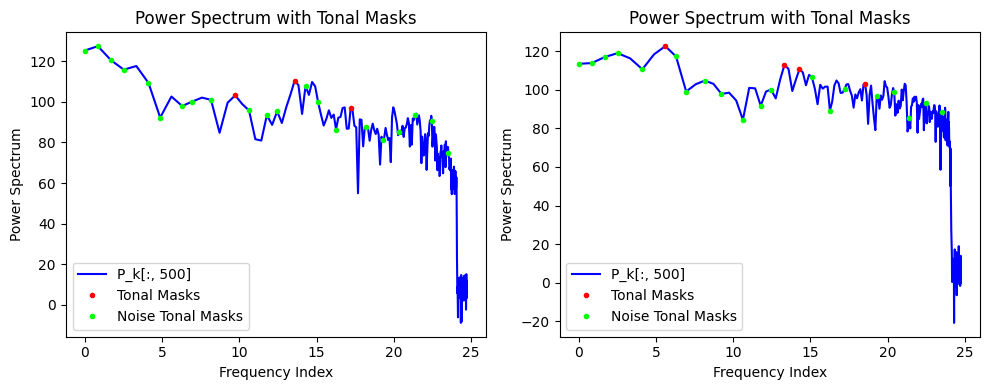

In [198]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(bark_freqs, P_k[:, window_0], color='blue', label='P_k[:, 500]')
# Overlay positions of tonal masks with red color
mask_indices = np.where(P_TMc[:, window_0] != 0)[0]
noise_mask_indices = np.where(P_NMc[:, window_0] != 0)[0]
plt.plot(bark_freqs[mask_indices], P_k[mask_indices, window_0], 'ro', label='Tonal Masks', markersize=3)
plt.plot(bark_freqs[noise_mask_indices], P_k[noise_mask_indices, window_0], 'o', color='lime', label='Noise Tonal Masks', markersize=3)
# Set labels and title
plt.xlabel('Frequency Index')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum with Tonal Masks')
# Add legend
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bark_freqs, P_k[:, window_1], color='blue', label='P_k[:, 500]')
# Overlay positions of tonal masks with red color
mask_indices = np.where(P_TMc[:, window_1] != 0)[0]
noise_mask_indices = np.where(P_NMc[:, window_1] != 0)[0]
plt.plot(bark_freqs[mask_indices], P_k[mask_indices, window_1], 'ro', label='Tonal Masks', markersize=3)
plt.plot(bark_freqs[noise_mask_indices], P_k[noise_mask_indices, window_1], 'o', color='lime', label='Noise Tonal Masks', markersize=3)
# Set labels and title
plt.xlabel('Frequency Index')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum with Tonal Masks')
# Add legend
plt.legend()
# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# 1.4

def tone_threshold(j, P_tm, b):
    
    """
    Individual masking threshold of a tone mask

    Args:
    j: Frequency of tone mask
    P_tm: Power of tone mask
    b: Array of frequencies in bark scale

    Returns:
    T_tm: Individual masking threshold
    """

    # Determine where tone mask j is in barks
    ToneMaskLocation = b[j]

    # Compute range in barks
    low = ToneMaskLocation - 3
    high = ToneMaskLocation + 8

    # Compute range in discrete frequencies
    low = np.where(b < low)[0][-1] if np.any(b < low) else 0
    high = np.where(b < high)[0][-1] if np.any(b < high) else len(b) - 1

    # Calculate SF(i,j)
    SF = np.zeros(high - low + 1)
    for i in range(low, high + 1):
        ToneMaskeeLocation = b[i]
        Db = ToneMaskeeLocation - ToneMaskLocation
        if -3 <= Db < -1:
            SF[i - low] = 17 * Db - 0.4 * P_tm + 11
        elif -1 <= Db < 0:
            SF[i - low] = (0.4 * P_tm + 6) * Db
        elif 0 <= Db < 1:
            SF[i - low] = -17 * Db
        elif 1 <= Db < 8.5:
            SF[i - low] = (0.15 * P_tm - 17) * Db - 0.15 * P_tm

    # Calculate individual tone threshold of tone mask j
    T_tm = np.zeros_like(b)
    for i in range(low, high + 1):
        T_tm[i] = SF[i - low] + P_tm - 0.275 * b[j] - 6.025

    return T_tm

In [233]:
#print(np.where(P_TMc[:, window_0] != 0)[0])
#print(P_TMc.shape)
discrete_coords = np.where(P_TMc[:, 0] > 0)[0]
#print(P_TMc[:, 0])
#print(discrete_coords)

[ 3 24 29 37 49]


In [212]:
# P_M  with shape (256, 1417)
P_M_3D = np.expand_dims(P_TMc, axis=2)  # Add a new axis along the third dimension
t_m_total = np.tile(P_M_3D, (1, 1, 256))  # Tile along the third dimension
print(t_m_total.shape)
print(t_m_total[255, 1416, :])

(256, 1417, 256)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [234]:
def SF(db, power):
    sf = 0
    if db >= -3 and db < -1:
        sf = 17*db-.4*power+11
    elif db >= -1 and db < 0:
        sf = (.4*power+6)*db
    elif db >= 0 and db < 1:
        sf = -17*db
    elif db >= 1 and db < 8:
        sf = (.15*power-17)*db-.15*power
    return sf

def T_M(P_M):
    # P_M  with shape (256, 1417)
    P_M_3D = np.expand_dims(P_M, axis=2)        # Add a new axis along the third dimension
    t_m_total = np.tile(P_M_3D, (1, 1, 256))    # Tile along the third dimension
                                                # t_m_total now has shape (256, 1417, 256)                                                

    for window in range(P_M.shape[1]):
        t_m = np.zeros((P_M.shape[0], P_M.shape[0]))
        discrete_coords = np.where(P_M[:, window] > 0)[0]
        #print(discrete_coords)
        for j in discrete_coords:
            #print(j)
            power = P_M[j, window]
            for i in range(t_m.shape[0]):
                db = bark_scale(i)-bark_scale(j)
                t_m_total[j, window, i] = power-0.275*bark_scale(j)+SF(db, power)
    return t_m_total            

In [239]:
T_TM = T_M(P_TMc)

In [237]:
T_NM = T_M(P_NMc)

In [245]:
# 1.5
def abs_thresh(f):
    return 3.64 * (f / 1000) ** (-0.8) - 6.5 * np.exp(-0.6 * (f / 1000 - 3.3) ** 2) + 10 ** (-3) * (f / 1000) ** 4

def T(t_nm, t_tm):
    t_g = np.zeros((t_nm.shape[0], t_nm.shape[1]))
    for window in range(t_nm.shape[1]):
        for i in range(t_nm.shape[0]):
            sum_tm = np.sum(10**(0.1*t_tm[i, window, :]))
            sum_nm = np.sum(10**(0.1*t_nm[i, window, :]))
            t_g[i, window] = np.log10(10**0.1*freqs[i]+sum_tm+sum_nm)
    return t_g


T_g = T(T_NM, T_TM)

In [246]:
T_g.shape

(256, 1417)

<StemContainer object of 3 artists>

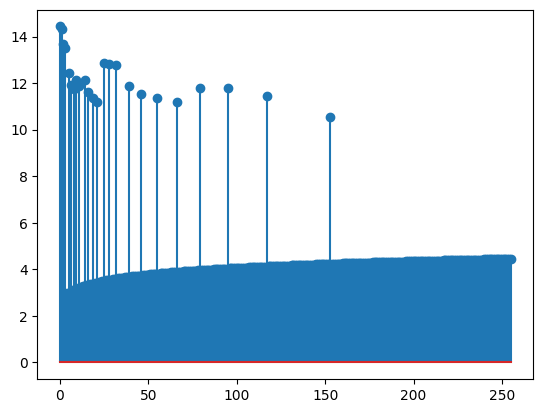

In [248]:
plt.stem(T_g[:, 500])

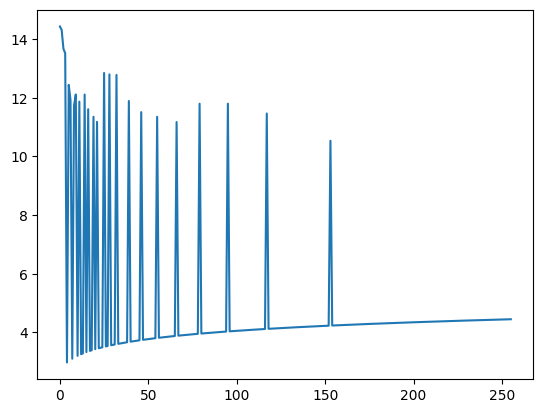

In [254]:
plt.plot(T_g[:, 500])